In [ ]:
#default_exp Experiment

In [ ]:
#hide
#export
from typing import Dict, Any, List
import pandas as pd

import sys
sys.path.append("..")

from hephaestus.AbstractMethod import *
from hephaestus.IOUtils import *
from hephaestus.DatasetConstruction import *
from hephaestus.HephaestusModel import *
from hephaestus.TrainModels import *

# Experiment

> This is where the science happens. Which model is best? Is it actually beneficial to use EditOperations over raw token sequences when training an NMT model?

In [ ]:
#export
class HephaestusModelEvaluation:
    """
    Helper class to centralize computations when evaluating the effectiveness of a `HephaestusModel`.
    
    Required Arguments:
    
    - `model`: The `HephaestusModel` to evaluate
    - `testSourceMethods`: A list of AbstractMethods representing the buggy abstract methods in the testing set. These
      methods should not appear at all in the training or validation sets that were used to train the model.
    - `testTargetMethods`: A list of AbstractMethods representing the fixed abstract methods in the testing set. These
      methods should not appear at all in the training or validation sets that were used to train the model.
    
    Optional Arguments:
    
    - `isControl`: Set to `True` if the model represents the control, i.e. the model was trained purely with
      AbstractMethods and not with EditOperations. Defaults to `False`.
  
    Once created, the `HephaestusModelEvaluation` will contain the following attributes which can be freely accessed:
    
    - `outputMethods`: A list of AbstractMethods which were translated from the given buggy (source) AbstractMethods.
      These represent the model's predictions of what it thinks the fixed methods are. Some of these entries may be
      `None`, representing failed predictions.
    - `numPerfectPredictions`: The number of `outputMethods` whose tokens exactly match the actual fixed method according
      to the provided `testTargetMethods`.
    - `perfectPredictionRatio`: The ratio of perfect predictions to total predictions, in the range [0, 1].
    - `numFailedPredictions`: The number of `outputMethods` which were not able to be predicted due to ill-formed
      EditOperations or other factors. These are represented by `None` values in `outputMethods`.
    - `failedPredictionRatio`: The ratio of failed predictions to total predictions, in the range [0, 1].
    - `trainingStats`: A Pandas DataFrame representing model information while it was training, as in
      `HephaestusModel.getTrainingStats`.
    """

    def __init__(self, 
        model: HephaestusModel,
        testSourceMethods: List[AbstractMethod],
        testTargetMethods: List[AbstractMethod],
        isControl: bool = False
    ) -> None:

        # use the model to determine output methods
        self.outputMethods = model.translate(testSourceMethods, applyEditOperations = not isControl)

        # sanity check -- make sure that the lengths of all lists of methods are equal
        if not len(testSourceMethods) == len(testTargetMethods) == len(self.outputMethods):
            raise RuntimeError("HephaestusModelEvaluation: method number mismatch")
        
        # determine number of perfect predictions and failed predictions
        self.numPerfectPredictions = 0
        self.numFailedPredictions = 0
        for outputMethod, targetMethod in zip(self.outputMethods, testTargetMethods):
            if outputMethod == targetMethod:
                self.numPerfectPredictions += 1
            if outputMethod is None:
                self.numFailedPredictions += 1
        
        # obtain perfect prediction and failed prediction ratios
        self.perfectPredictionRatio = self.numPerfectPredictions / len(self.outputMethods)
        self.failedPredictionRatio = self.numFailedPredictions / len(self.outputMethods)
        
        # get the training statistics
        self.trainingStats = model.getTrainingStats()

## Helper functions

In [ ]:
#export
def plotTrainingAccuracies(
    evaluations: List[HephaestusModelEvaluation],
    lineLabels: List[str],
    title: str
) -> None:
    """
    Plots the training accuracies of the given `evaluations` as a line graph per training step. The line labels are the
    given `lineLabels`. The title is the given `title`.
    """
    
    # create dataframe
    data = {}
    for evaluation, label in zip(evaluations, lineLabels):
        data[label] = evaluation.trainingStats["trainAccuracy"].to_list()
    frame = pd.DataFrame(data, index = evaluations[0].trainingStats["step"].to_list())
    
    # create plot
    plot = frame.plot.line(
        title = title,
        xlabel = "Training Step",
        ylabel = "Training Accuracy %",
        grid = True
    )

In [ ]:
#export
def plotPerfectPredictionAccuracies(
    evaluations: List[HephaestusModelEvaluation],
    xLabels: List[str],
    title: str
) -> pd.DataFrame:
    """
    Plots the perfect prediction accuracies of the given `evaluations` as a bar graph. The x-axis labels are the
    given `xlabels`. The title of the graph is the given `title`. Returns the dataframe used to create the graph.
    """
    
    # create dataframe
    frame = pd.DataFrame({
        "model": xLabels,
        "accuracy": [100 * e.perfectPredictionRatio for e in evaluations]
    })

    # create plot
    plot = frame.plot.bar(
        x = "model",
        y = "accuracy",
        ylim = (0, max(frame["accuracy"] + 2)),
        xlabel = "Model",
        ylabel = "Perfect Prediction Accuracy %",
        title = title,
        rot = 0
    )

    # annotate the bars with their values
    for p in plot.patches:
        plot.annotate("{:.1f}%".format(p.get_height()), (p.get_x() + 0.1, p.get_height() + 0.5))
    
    return frame

In [ ]:
#export
def plotFailedPredictionRates(
    evaluations: List[HephaestusModelEvaluation],
    xLabels: List[str],
    title: str
) -> pd.DataFrame:
    """
    Plots the failed prediction rates of the given `evaluations` as a bar graph. The x-axis labels are the
    given `xlabels`. The title of the graph is the given `title`. Returns the dataframe used to create the graph.
    """
    
    # create dataframe
    frame = pd.DataFrame({
        "model": xLabels,
        "rate": [100 * e.failedPredictionRatio for e in evaluations]
    })

    # create plot
    plot = frame.plot.bar(
        x = "model",
        y = "rate",
        ylim = (0, max(frame["rate"] + 0.5)),
        xlabel = "Model",
        ylabel = "Failed Prediction Rate %",
        title = title,
        rot = 0
    )

    # annotate the bars with their values
    for p in plot.patches:
        plot.annotate("{:.2f}%".format(p.get_height()), (p.get_x() + 0.08, p.get_height() + 0.03))
    
    return frame

## Preparation

Collect buggy and fixed methods from the testing dataset. These AbstractMethods do not appear at all in the training or validation data.

In [ ]:
testBuggyMethods = readAbstractMethodsFromFile(DATA_SMALL_METHODS_TEST_BUGGY)
testFixedMethods = readAbstractMethodsFromFile(DATA_SMALL_METHODS_TEST_FIXED)

## Default Parameters

Get the `HephaestusModelEvaluation` for each model which was trained with the deafault parameters.

In [ ]:
#collapse_output
controlEvaluation = HephaestusModelEvaluation(
    HephaestusModel(MODEL_DEFAULT_CONTROL),
    testBuggyMethods,
    testFixedMethods,
    isControl = True
)

[2021-04-24 17:00:31,844 INFO] Translating shard 0.
[2021-04-24 17:01:06,728 INFO] PRED AVG SCORE: -0.0585, PRED PPL: 1.0603


In [ ]:
#collapse_output
basicEvaluation = HephaestusModelEvaluation(
    HephaestusModel(MODEL_DEFAULT_BASIC),
    testBuggyMethods,
    testFixedMethods
)

[2021-04-24 16:59:22,623 INFO] Translating shard 0.
[2021-04-24 17:00:25,716 INFO] PRED AVG SCORE: -0.0683, PRED PPL: 1.0707


In [ ]:
#collapse_output
strictEvaluation = HephaestusModelEvaluation(
    HephaestusModel(MODEL_DEFAULT_STRICT),
    testBuggyMethods,
    testFixedMethods
)

[2021-04-24 17:01:12,162 INFO] Translating shard 0.
[2021-04-24 17:01:35,413 INFO] PRED AVG SCORE: -0.4507, PRED PPL: 1.5694


In [ ]:
#collapse_output
looseEvaluation = HephaestusModelEvaluation(
    HephaestusModel(MODEL_DEFAULT_LOOSE),
    testBuggyMethods,
    testFixedMethods
)

[2021-04-24 17:01:41,084 INFO] Translating shard 0.
[2021-04-24 17:02:01,205 INFO] PRED AVG SCORE: -0.4528, PRED PPL: 1.5728


### Training Accuracies

What were the training accuracies of the models?

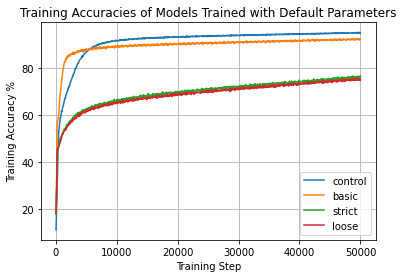

In [ ]:
plotTrainingAccuracies(
    evaluations = [controlEvaluation, basicEvaluation, strictEvaluation, looseEvaluation],
    lineLabels =  ["control",         "basic",         "strict",         "loose"],
    title = "Training Accuracies of Models Trained with Default Parameters"
)

### Perfect prediction accuracies

How good were the models at fixing the bugs in the buggy AbstractMethods exactly as the developers did?

,model,accuracy
0,control,14.721508
1,basic,7.986290
2,strict,7.146530
3,loose,7.180805


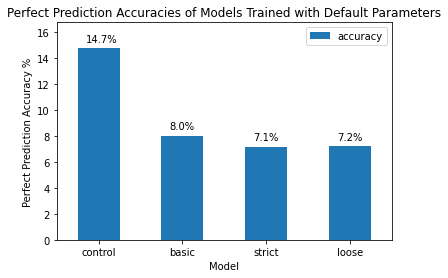

In [ ]:
plotPerfectPredictionAccuracies(
    evaluations = [controlEvaluation, basicEvaluation, strictEvaluation, looseEvaluation],
    xLabels =     ["control",         "basic",         "strict",         "loose"],
    title = "Perfect Prediction Accuracies of Models Trained with Default Parameters"
)

### Failed prediction rates

How often did the models fail to output an `AbstractMethod`?

,model,rate
0,control,0.000000
1,basic,0.377035
2,strict,0.274207
3,loose,0.582691


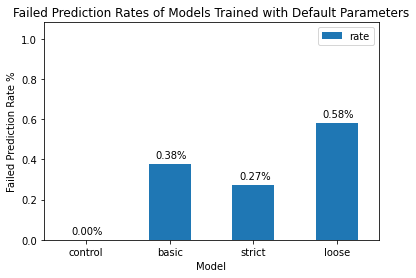

In [ ]:
plotFailedPredictionRates(
    evaluations = [controlEvaluation, basicEvaluation, strictEvaluation, looseEvaluation],
    xLabels =     ["control",         "basic",         "strict",         "loose"],
    title = "Failed Prediction Rates of Models Trained with Default Parameters"
)

### Analysis

The perfect prediction accuracy is the most important metric here; it describes how well the model can actually function as a "bug fixer". The control model (trained only with AbstractMethods) performs significantly better than any of the models trained with EditOperations in this regard. These perliminary results give evidence that training NMT models with EditOperations is not beneficial over the standard approach.